# Question 1
Identify protein features that allow to distinguish physiological and non-physiological
dimers, and give your opinions on their biological relevance and structural context.
Support your conclusions with figures or calculations that you obtained during the
analysis.


Personal notes:
    important points:
- Crystal structures maybe obtained in conditions that don't represent the physiological conditions leading to structures that may not represent the physiologically meaningful assembly. (is this what all we are calling non-physiological dimers?)
- Proteins form many contacts whose sole function is to stabilize the crystal lattice. Deciding which of these contacts are physiologically meaningful can be difficult. (maybe identifying important contacts is an important feature)
- Methods to methods to evaluate the interface:
       PISA: chemical and structural properties of interfaces, and EPPIC: geometric measures and sequence conservation.
- Question: How to define a non-physiological binding mode?
- Check scoring functions to evaluate binding interfaces.
- Check Docking Benchmark
- Definition of physiological dimer in this dataset relies on conservation of 3D structure of the interface (ProtCID and QSalign)
- IMPORTANT: on average engage in higher affinity interactions than their non-physiological counterparts highly correlated to the interface area (they included only non-physiological complexes with average similar or larger interface areas. So in this case it should be less relevant.


In [76]:
#To facilitate, all imports are here:
import pandas as pd
import math
from scipy.stats import ttest_ind
import os
from Bio import PDB
#from pymol import cmd
from matplotlib import pyplot as plt
import glob
import numpy as np

#all sklearn imports

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

#all tensorflow imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Concatenate, Dense, Dropout, Bidirectional, LSTM, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import ops as K
import keras



To start this analysis, I'll take a look in the distributions of the features. I was considering calculating a p-value to estimate the significance in the differences, but it seems very clear just by looking at the differences. I also did a small literature review about the methods and the features tha I'll  discuss later in this document:

I just wrote a basic function that plot a histogram to every single feature column and separates between Physiological and non-physiological: I added the t-test but it is not appropriate...

In [43]:
def plot_histograms_by_physiological(df, bins=30, alpha=0.5, ncols=3):

    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    for col in ["Unnamed: 0", "physiological"]:
        if col in numeric_cols:
            numeric_cols.remove(col)
    labels = pd.unique(df["physiological"])
    group1, group2 = labels
    n_features = len(numeric_cols)
    nrows = math.ceil(n_features / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()
    for i, col in enumerate(numeric_cols):
        ax = axes[i]

        vals1 = df[df["physiological"] == group1][col].dropna()
        vals2 = df[df["physiological"] == group2][col].dropna()

        stat, p = ttest_ind(vals1, vals2, equal_var=False)
        for lab in labels:
            subset = df[df["physiological"] == lab][col].dropna()
            if subset.empty:
                continue
            ax.hist(subset, bins=bins, alpha=alpha, label=f"physiological={lab}")
        ax.set_title(col, fontsize=10)
        ax.text(0.5, -0.25, f"p_value = {p:.2e}", ha="center", va="center",
                transform=ax.transAxes, fontsize=9)
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.legend(fontsize=8)
    for j in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()




Plotting the histograms:

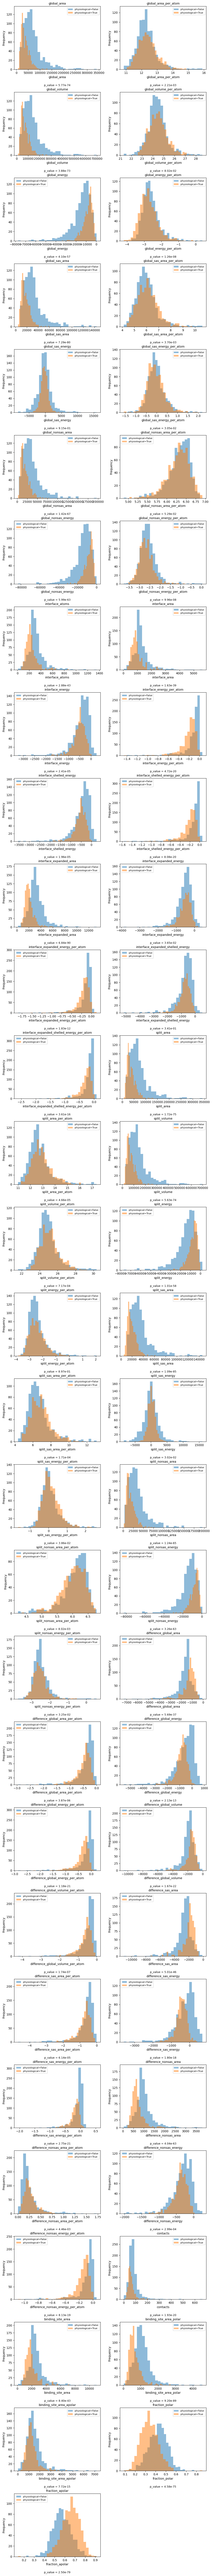

In [44]:
df = pd.read_csv("Features.csv")
plot_histograms_by_physiological(df, ncols=2)

## General observations about the overview of the features dists:

Starting the analysis by Global features:

**Global volume, global area, global energy, split volume, split area, split energy**: Alone, those features shouldn't be important and if they are decisive for the classification it must be something exclusive for this dataset of structures and not for a real world situation (whether two proteins interact in a specific binidng mode or not shouldn't be dependent of their size).  note: in the paper they say that the energy correlates to the area of the interface that is why I included it here.

** Difference




# Problems with the dataset:

Before proceeding with the analysis: Even though in the main document it is announced that data sets are ready to use and doesn't require any pre-treatment. I found a couple of structures that were not right at all:

->7 structures have more than 2 chains and look very wierd I selected a couple of photos of it:
(more than two chains: 1ujk_3, 2axi_3, 1f1j_5, 3hna_3, 1lvb_5, 1lvl_4, 4tt4_1)


<img src="images/2axi_3.png" alt="2axi_3" width="200"/>

-> Also, some steric clashes also are visible in some structures (I wont proceed with a sterical clashes check, but this should be pointed out):

<img src="images/5yii_1.png" alt="5yii_1" width="200"/>

-> Moreover, a clear mistake in generating the .pdb files is that 300 structures have duplicated atom numbers (atom numbering re-start from 1 in the other chain), it shouldn't cause errors, but it is not a proper pdb formating, so I fixed it using pymol: see the exemple: "./images/3e7p_1.pdb"

<img src="images/wrong_numbering.png" alt="wrong_numbering" width="200"/>





In [2]:
pdb_list=os.listdir("01_PDB_legacy_3dcomplex_expanded")
count=0
final_set=[]
for pdb in pdb_list:
    if "clean.pdb" in pdb:
        parser = PDB.PDBParser(QUIET=True)
        structure = parser.get_structure("structure", f"01_PDB_legacy_3dcomplex_expanded/{pdb}")

        chain_ids = set()
        for model in structure:
            for chain in model:
                chain_ids.add(chain.id)
            chain_ids = list(chain_ids)
            if len(chain_ids)>2 or len(chain_ids)<=1:
                print(f"More than two chain IDs found: {pdb} ->", ", ".join(sorted(chain_ids)))
            else:
                # I used pymol to correct the pdb files with duplicated atom numbers:
                #cmd.load(f"01_PDB_legacy_3dcomplex_expanded/{pdb}")
                #cmd.save("01_PDB_legacy_3dcomplex_expanded/"+pdb,pdb[:-4])
                os.system(f"python Surfaces/surface_cont.py -f 01_PDB_legacy_3dcomplex_expanded/{pdb} -c1 {chain_ids[0]} -c2 {chain_ids[1]} -o Surfaces_results/{pdb[:-4]}_output.csv -def Surfaces/AMINO_FlexAID.def -dat Surfaces/FlexAID.dat")
                final_set.append(pdb[:-4])
                count+=1
                print(pdb[:-10],count)



NameError: name 'os' is not defined

In [2]:
hydrophobic = {"VAL", "ILE", "LEU", "ALA", "PHE", "TRP", "MET", "PRO", "TYR"}
polar = {"SER", "THR", "ASN", "GLN", "HIS", "TYR", "CYS"}
charged_pos = {"LYS", "ARG", "HIS"}
charged_neg = {"ASP", "GLU"}

def classify_interaction(res1, res2):
    r1, r2 = res1[:3], res2[:3]
    if r1 in hydrophobic and r2 in hydrophobic:
        return "hydrophobic"
    if r1 in polar and r2 in polar:
        return "polar"
    if (r1 in charged_pos and r2 in charged_pos) or (r1 in charged_neg and r2 in charged_neg):
        return "charged_same"
    if (r1 in charged_pos and r2 in charged_neg) or (r1 in charged_neg and r2 in charged_pos):
        return "charged_opposite"
    if (r1 in polar and r2 in hydrophobic) or (r2 in polar and r1 in hydrophobic):
        return "polar-hydrophobic"
    if ((r1 in charged_pos | charged_neg) and (r2 in polar | hydrophobic)) or \
       ((r2 in charged_pos | charged_neg) and (r1 in polar | hydrophobic)):
        return "charged-mixed"
    return "other"

def extract_features(file_path):
    df = pd.read_csv(file_path, header=None, names=["res1", "res2", "energy"])

    unfavorable = (df["energy"] > 0).sum()
    favorable = (df["energy"] <= 0).sum()

    df["interaction_type"] = df.apply(lambda r: classify_interaction(r["res1"], r["res2"]), axis=1)
    counts = df["interaction_type"].value_counts().to_dict()

    categories = ["hydrophobic", "polar", "charged_same", "charged_opposite", 
                  "polar-hydrophobic", "charged-mixed", "other"]
    for cat in categories:
        counts.setdefault(cat, 0)
    
    features = {
        "file": os.path.basename(file_path),
        "unfavorable_interactions": int(unfavorable),
        "favorable_interactions": int(favorable),
        **counts
    }
    return features

def process_directory(input_dir, output_csv="features_summary.csv"):
    all_files = glob.glob(os.path.join(input_dir, "*_list.txt"))
    results = []
    for f in all_files:
        results.append(extract_features(f))
    df_out = pd.DataFrame(results)
    df_out.to_csv(output_csv, index=False)
    print(f"Saved summary to {output_csv}")

process_directory("Surfaces_results", "contact_features.csv")



Saved summary to contact_features.csv


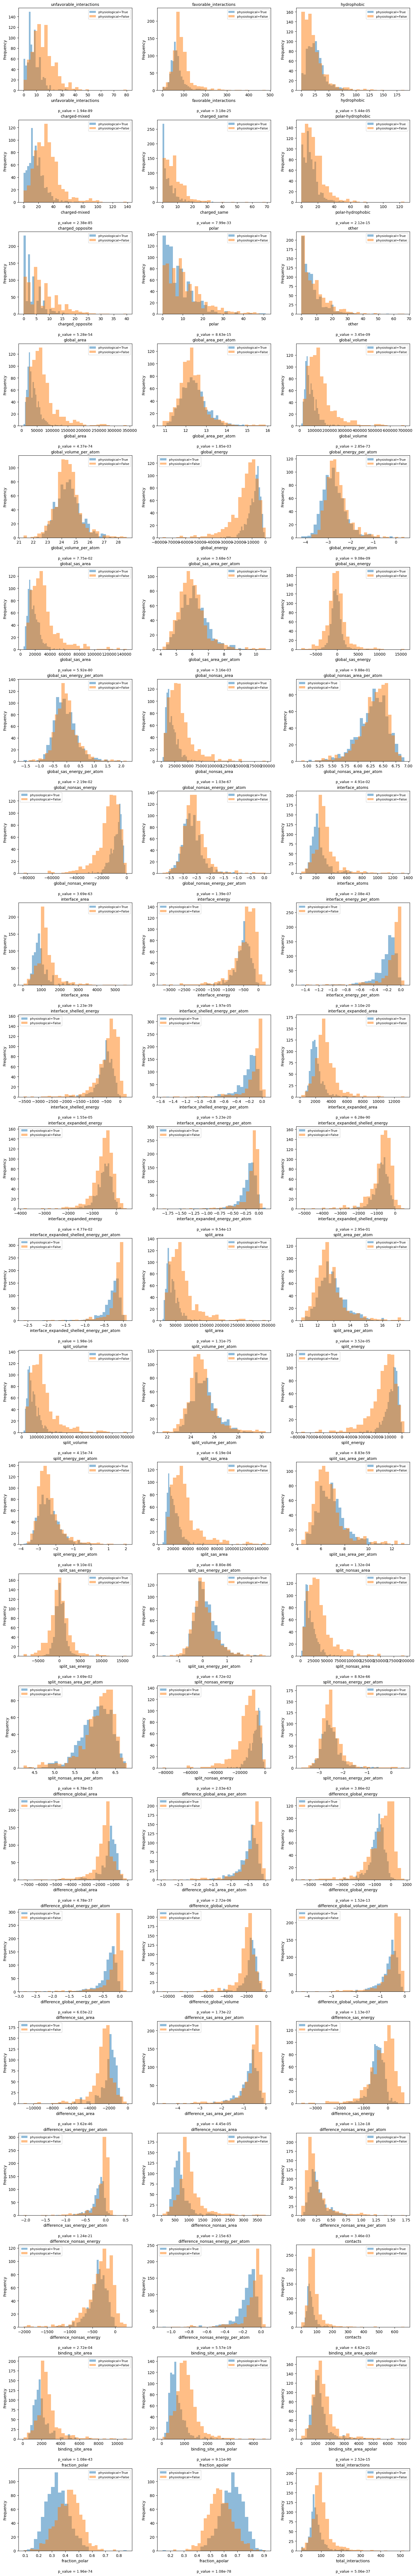

Saved: combined_contact_features.csv


,file,unfavorable_interactions,favorable_interactions,hydrophobic,charged-mixed,charged_same,polar-hydrophobic,charged_opposite,polar,other,...,difference_nonsas_energy,difference_nonsas_energy_per_atom,contacts,binding_site_area,binding_site_area_polar,binding_site_area_apolar,fraction_polar,fraction_apolar,difficult,total_interactions
0,3lyn_1_clean_output_list.txt,3,63,27,24,5,4,2,2,2,...,-457.36228,-0.22310,40,1833.49,763.21,1070.27,0.416261,0.583734,False,66
1,2ym0_5_clean_output_list.txt,11,69,35,18,2,17,2,2,4,...,-464.22800,-0.15146,64,2283.83,627.10,1656.74,0.274583,0.725422,False,80
2,1yad_2_clean_output_list.txt,3,64,23,15,4,13,2,0,10,...,-297.77800,-0.10170,48,1558.97,456.39,1102.59,0.292751,0.707255,False,67
3,1k6i_3_clean_output_list.txt,10,69,25,25,10,4,10,1,4,...,-428.75700,-0.08473,64,2100.95,916.45,1184.49,0.436207,0.563788,False,79
4,2qlx_2_clean_output_list.txt,13,110,37,32,6,27,10,10,1,...,-664.21700,-0.41001,104,2992.70,1125.41,1867.29,0.376052,0.623948,False,123


In [4]:
contact_features_path = "contact_features.csv"
labels_path = "Features.csv"
output_path = "combined_contact_features.csv"


cf = pd.read_csv(contact_features_path)
labels = pd.read_csv(labels_path)

def to_pdbid(fname: str) -> str:
    base = os.path.basename(fname)
    return base.replace("_clean_output_list.txt", "")

cf["pdb-id"] = cf["file"].apply(to_pdbid)

columns_to_keep = ["pdb-id", "physiological"]
extra_numeric = [c for c in labels.columns
                 if c not in columns_to_keep and pd.api.types.is_numeric_dtype(labels[c])]
labels_trim = labels[columns_to_keep + extra_numeric]

merged = cf.merge(labels_trim, on="pdb-id", how="left")

if {"unfavorable_interactions", "favorable_interactions"}.issubset(merged.columns):
    merged["total_interactions"] = (
        merged["unfavorable_interactions"].fillna(0) +
        merged["favorable_interactions"].fillna(0)
    )

if merged["physiological"].dtype == object:
    merged["physiological"] = merged["physiological"].str.strip().map(
        {"physiological": True, "non-physiological": False}
    )


plot_histograms_by_physiological(merged, bins=30, alpha=0.5, ncols=3)

merged.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

merged.head()

In [6]:
df=pd.read_csv("combined_contact_features.csv")
drop=["physiological", "file", "pdb-id", "Unnamed: 0","difficult","interface_expanded_area"]
for col in df.columns:
    if "global" in col or "split" in col:
        drop.append(col)


X = df.drop(columns=drop)
y = df["physiological"].astype(int)

#is the data set balanced??
print(df.loc[df.physiological==0,].shape[0], df.loc[df.physiological!=0,].shape[0])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#Random forest

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

#LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_scaled, y_train)


y_pred_lr = log_reg.predict(X_test_scaled)





835 835


In [7]:
#Model evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f" Accuracy: RF {accuracy_rf}, LR {accuracy_lr}")


#Confusion matrixes:

cm_rf=confusion_matrix(y_test, y_pred_rf)
cm_lr=confusion_matrix(y_test, y_pred_lr)

print("Confusion Matrix_rf \n", cm_rf)
print("Confusion_Matrix_lr \n", cm_lr)

#false discovery rates:
def fdr(cm):
    TN, FP, FN, TP = cm.ravel()

    if (TP+FP) > 0:

        fdr = FP/(TP+FP)

    else:

        fdr = 0.0
    return fdr

fdr_rf=fdr(cm_rf)
fdr_lr=fdr(cm_lr)

print(f"FDR RF:{fdr_rf}\n")
print(f"FDR LR:{fdr_lr}\n")


#make report:
report_rf = classification_report(y_test, y_pred_rf)
report_lr = classification_report(y_test, y_pred_lr)

print("Report RF:\n",report_rf)
print("Report LR:\n", report_lr)

 Accuracy: RF 0.7994011976047904, LR 0.8053892215568862
Confusion Matrix_rf 
 [[135  32]
 [ 35 132]]
Confusion_Matrix_lr 
 [[128  39]
 [ 26 141]]
FDR RF:0.1951219512195122

FDR LR:0.21666666666666667

Report RF:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       167
           1       0.80      0.79      0.80       167

    accuracy                           0.80       334
   macro avg       0.80      0.80      0.80       334
weighted avg       0.80      0.80      0.80       334

Report LR:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       167
           1       0.78      0.84      0.81       167

    accuracy                           0.81       334
   macro avg       0.81      0.81      0.81       334
weighted avg       0.81      0.81      0.81       334



In [8]:
importances_rf = rf.feature_importances_


print("Feature Importances RF:\n", pd.DataFrame({"Features":X.columns.tolist(),"Importance":importances_rf}).sort_values(by="Importance", ascending=False).reset_index(drop=True))

importances_lr = log_reg.coef_[0]

feature_importances_lr = (
    pd.DataFrame({
        "Features": X.columns.tolist(),
        "Coefficient": importances_lr,
        "Abs_Importance": abs(importances_lr)
    })
    .sort_values(by="Abs_Importance", ascending=False)
    .reset_index(drop=True)
)

print("Feature Importances (Logistic Regression):\n", feature_importances_lr)


Feature Importances RF:
                                       Features  Importance
0                       difference_nonsas_area    0.090734
1                      binding_site_area_polar    0.077746
2               difference_sas_energy_per_atom    0.063918
3                            binding_site_area    0.060490
4            interface_shelled_energy_per_atom    0.052025
5                    interface_energy_per_atom    0.048466
6                          difference_sas_area    0.044445
7            difference_nonsas_energy_per_atom    0.040846
8                        difference_sas_energy    0.035900
9                                charged-mixed    0.035253
10                             interface_atoms    0.027148
11                    interface_shelled_energy    0.026569
12                              interface_area    0.026542
13                             fraction_apolar    0.025340
14                              fraction_polar    0.025141
15                    unfavorab

In [9]:
r = permutation_importance(rf, X_test, y_test,
                           n_repeats=30)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns.tolist()[i]: <8}"
              f"{r.importances_mean[i]: .3f}"
              f" +/- {r.importances_std[i]: .3f}")

difference_nonsas_area 0.023 +/-  0.011
contacts 0.017 +/-  0.006
interface_shelled_energy_per_atom 0.014 +/-  0.006
interface_expanded_energy_per_atom 0.014 +/-  0.004
difference_nonsas_energy_per_atom 0.012 +/-  0.006
binding_site_area_apolar 0.011 +/-  0.005
difference_nonsas_energy 0.010 +/-  0.004
interface_expanded_shelled_energy 0.010 +/-  0.005


# Making a fancier model

I decided to use a basic sequence-based deep learning for PPI classification using the contact energy matrix we calculated for each complex using surfaces script in the previous steps.
It is BiLSTM-based and I got to know this idea based on a test I was doing with a colleague for a similar project for ppi-prediction. She gave me some hints about what she used in her model and I developed my own version based on what we discussed.

It takes 3 vectors as an input representing the contacts in the interface:
1 - residues in one chain
2 - residues in the other chain
3 - energy calculated with surfaces

The output is binary: physiological=1 non-physiological=0

For embedding, I got whatever chatGPT suggested. For the model parameters I tried a couple (didnt use any specific methodolgy) unitil I got something with better accuracy than random... but I couldn't make it better than RF or LR :/

Given the fact I didn't had much time, this model wasn't that well planned and I ended up with an architecture resulted from a trial and error methodology :)

Leaving some notes for future me about useful material for this code for future improvement:

For learning more about the basic concepts: this video: https://www.youtube.com/watch?v=atYPhweJ7ao, this article: https://www.sciencedirect.com/science/article/pii/S0010482524015348#sec7









## Preprocessing:

-Resi Encoding: Residues are identified by three-letter codes (ALA, LYS, etc.) take all residues across all files, lowercase them, and maps each residue type to an integer. note: +1 so that 0 is reserved for padding (because the vectors have different sizes).

-energy scaling: concatenates and make values in between -1 and 1

-padding

-Labels: 1 physiologica - non-physiological




In [77]:
keras.utils.set_random_seed(42)

def encode_series(s: pd.Series) -> np.ndarray:

    return encoder.transform(s.str[:3].str.lower()) + 1

def extract_id(path: str) -> str:
    base = os.path.basename(path)
    parts = base.split("_")
    return "_".join(parts[:2]) if len(parts) >= 2 else parts[0]

contact_files = sorted(glob.glob("Surfaces_results/*_list.txt"))

all_data = []
for path in contact_files:
    df = pd.read_csv(path, header=None, names=["res1","res2","energy"])
    all_data.append(df)

all_residues = (pd.concat(all_data)[["res1","res2"]].stack().str[:3].str.lower().unique())
encoder = LabelEncoder().fit(all_residues)


all_energy = np.concatenate([d["energy"].values for d in all_data])
scaler = StandardScaler().fit(all_energy.reshape(-1, 1))

# Pad sequences to the same length
max_len = max(len(df) for df in all_data)
r1_list, r2_list, en_list = [], [], []
for d in all_data:
    r1_list.append(encode_series(d["res1"]).astype("int32"))
    r2_list.append(encode_series(d["res2"]).astype("int32"))
    en_scaled = scaler.transform(d["energy"].values.reshape(-1,1)).ravel().astype("float32")
    en_list.append(en_scaled)

r1_pad = pad_sequences(r1_list, maxlen=max_len, padding="post", truncating="post", value=0)
r2_pad = pad_sequences(r2_list, maxlen=max_len, padding="post", truncating="post", value=0)
en_pad = pad_sequences(en_list, maxlen=max_len, padding="post", truncating="post", value=0.0).astype("float32")

# Labelling
labels = pd.read_csv("Features.csv")
id_map = dict(zip(labels["pdb-id"].astype(str), labels["physiological"].astype(int)))

ids = [extract_id(p) for p in contact_files]
missing = [i for i in ids if i not in id_map]

y = np.array([id_map[i] for i in ids], dtype="float32")

# Train/Test split:

normal: 5 fold cv

In [79]:
idx_all = np.arange(len(y))

# 20% test
idx_train, idx_test = train_test_split(idx_all, test_size=0.20, random_state=42, stratify=y)

# For the rest: 80% train 20% as val
idx_train, idx_val = train_test_split(idx_train, test_size=0.20, random_state=42, stratify=y[idx_train])

r1_tr, r1_va, r1_te = r1_pad[idx_train], r1_pad[idx_val], r1_pad[idx_test]
r2_tr, r2_va, r2_te = r2_pad[idx_train], r2_pad[idx_val], r2_pad[idx_test]
en_tr, en_va, en_te = en_pad[idx_train], en_pad[idx_val], en_pad[idx_test]
y_tr,  y_va,  y_te  = y[idx_train],    y[idx_val],    y[idx_test]

print("train:", len(y_tr), "val:", len(y_va), "test:", len(y_te))

train: 1068 val: 268 test: 334


# The model:







In [67]:
max_len = r1_pad.shape[1]
vocab_size = len(encoder.classes_) + 1
emb_dim = 32

#inputs
r1_in = Input(shape=(max_len,), dtype="int32", name="r1")
r2_in = Input(shape=(max_len,), dtype="int32", name="r2")
en_in = Input(shape=(max_len, 1), dtype="float32", name="en")

#embeddings and mask... note: mask for avoid using zeros as variables and introducing noise
emb = Embedding(vocab_size, emb_dim, mask_zero=True, name="res_embedding")
r1_e = emb(r1_in)  # (B,L,E)
r2_e = emb(r2_in)  # (B,L,E)

pair_e = Concatenate(axis=-1, name="pair_concat")([r1_e, r2_e])     # (B,L,2E)
pair   = Concatenate(axis=-1, name="add_energy")([pair_e, en_in])   # (B,L,2E+1)

seq_mask = Lambda(lambda t: K.not_equal(t, 0), name="seq_mask")(r1_in)  # (B,L) bool

# Layers:
h = Bidirectional(LSTM(64, dropout=0.25, return_sequences=False),name="bilstm")(pair, mask=seq_mask)

h = Dropout(0.4, name="head_dropout")(h)
h = Dense(64, activation="relu", name="fc1")(h)
h = Dropout(0.3, name="head_dropout2")(h)
out = Dense(1, activation="sigmoid", name="out")(h)

model = Model(inputs=[r1_in, r2_in, en_in], outputs=out)

model.compile(optimizer=Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=[AUC(name="auc"), "accuracy"])




Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 987ms/step - accuracy: 0.5561 - auc: 0.4995 - loss: 0.6919 - val_accuracy: 0.2395 - val_auc: 0.4900 - val_loss: 0.7426 - learning_rate: 1.0000e-04
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 965ms/step - accuracy: 0.5621 - auc: 0.5135 - loss: 0.6869 - val_accuracy: 0.2365 - val_auc: 0.4955 - val_loss: 0.7394 - learning_rate: 1.0000e-04
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 936ms/step - accuracy: 0.5599 - auc: 0.4974 - loss: 0.6898 - val_accuracy: 0.2365 - val_auc: 0.5147 - val_loss: 0.7363 - learning_rate: 1.0000e-04
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 962ms/step - accuracy: 0.5591 - auc: 0.5117 - loss: 0.6869 - val_accuracy: 0.2365 - val_auc: 0.5372 - val_loss: 0.7353 - learning_rate: 1.0000e-04
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5546 - auc: 0.5033 - loss: 0.6901 - val_accuracy: 0.2365 - val_auc: 0.5491 - val_loss: 0.7353 - learning_rate: 1.0000e-04
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - 

## Lets train it!!!

In [ ]:
# it was taking too long, so:
es  = EarlyStopping(monitor="val_auc", mode="max", patience=12, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", patience=4, factor=0.5, min_lr=1e-6, verbose=1)


history = model.fit(
    {"r1": r1_tr, "r2": r2_tr, "en": en_tr[..., None]},
    y_tr,
    validation_data=(
        {"r1": r1_va, "r2": r2_va, "en": en_va[..., None]},
        y_va
    ),
    epochs=200,
    batch_size=128,
    callbacks=[es, rlr],
    verbose=1,
    shuffle=True
)


# Did we do better than random at least????

In [78]:
test_loss, test_auc, test_acc = model.evaluate({"r1": r1_te, "r2": r2_te, "en": en_te[..., None]},y_te,verbose=0)

print(f"\nTest -> loss: {test_loss:.4f} | AUC: {test_auc:.4f} | acc: {test_acc:.4f}")

y_prob = model.predict({"r1": r1_te, "r2": r2_te, "en": en_te[..., None]}, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_te, y_prob))
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))
print("Classification report:\n", classification_report(y_te, y_pred, digits=4))


Test -> loss: 0.5011 | AUC: 0.8351 | acc: 0.7605
ROC AUC: 0.8350604180859836
Accuracy: 0.7604790419161677
Confusion matrix:
 [[112  55]
 [ 25 142]]
Classification report:
               precision    recall  f1-score   support

         0.0     0.8175    0.6707    0.7368       167
         1.0     0.7208    0.8503    0.7802       167

    accuracy                         0.7605       334
   macro avg     0.7692    0.7605    0.7585       334
weighted avg     0.7692    0.7605    0.7585       334



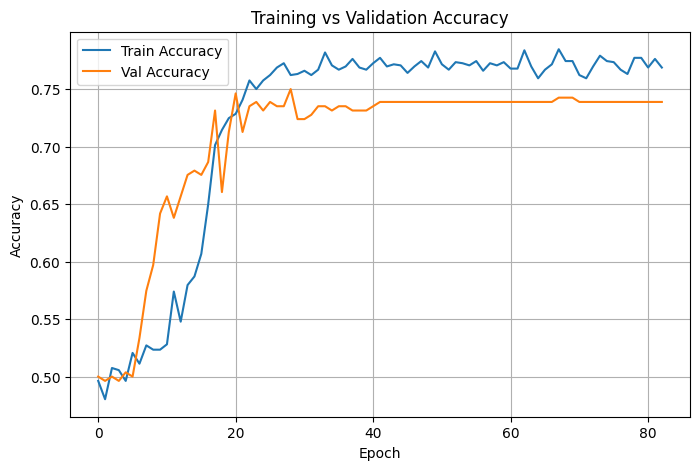

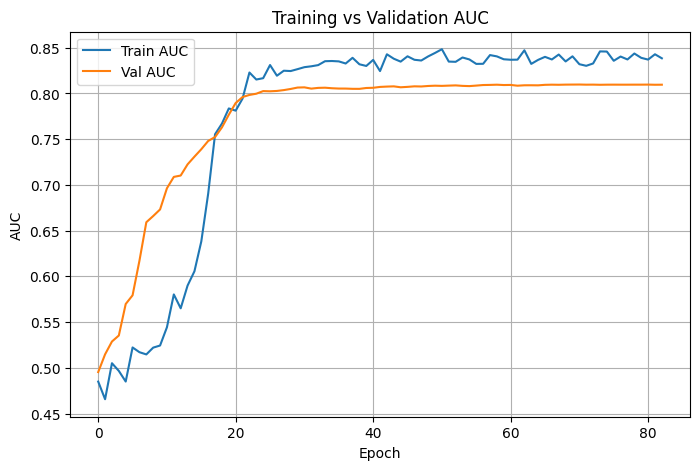

In [80]:
hist = history.history

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(hist["accuracy"], label="Train Accuracy")
plt.plot(hist["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot AUC
plt.figure(figsize=(8,5))
plt.plot(hist["auc"], label="Train AUC")
plt.plot(hist["val_auc"], label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training vs Validation AUC")
plt.legend()
plt.grid(True)
plt.show()